In [2]:
import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import json
import collections, functools, operator

In [3]:
df = pd.read_csv(r'/Users/dylanfu/Desktop/MOVELab_Work/sg_ca_data.csv')

In [4]:
#change table formatting
df["date_range_start"] = pd.to_datetime(df["date_range_start"]) #measurement period start time - in datetime
df["county_fips"] = df["county_fips"].astype(str) # county FIPS as str
df["cbg_fips"] = df["cbg_fips"].astype(str)# census block group FIPS as str
df["origin_census_block_group"] = df["origin_census_block_group"].astype(str) # origin(?) census block group FIPS as str

In [5]:
# weeklydf = df.groupby(['county_fips',pd.Grouper(key='date_range_start', freq='W-MON')],as_index= False) # group by county FIPS and week
weeklydf = df.groupby(['county_fips',pd.Grouper(key='date_range_start', freq='W-MON')])

In [6]:
# function for converting x from series to list of dicts (originally JSON), summing the contents to get weekly numbers
def contenttester(x):
    for i in range(len(x)):
        d = json.loads(x[i])
        x[i] = d
    return dict(functools.reduce(operator.add,map(collections.Counter, x)))

#aggregating data by week following sort 
weeklydf = weeklydf.agg({'device_count':'sum',
                    'distance_traveled_from_home':'median',
                    'bucketed_distance_travelled': lambda x: contenttester(x.tolist()),
                    'completely_home_device_count':'sum',
                    'median_percentage_time_home':'median',
                    'mean_distance_traveled_from_home':'mean'})

# cleaning NaN values -- replacing with mean value

mean_value = weeklydf["mean_distance_traveled_from_home"].mean()
weeklydf["mean_distance_traveled_from_home"].fillna(value=mean_value, inplace=True)
weeklydf.reset_index(inplace = True)


We can use the midpoints of the buckets of bucketed_distance_travelled as weights for calculating the weighted average. However, the bucket for catching large values -- ">50000" is right-censored/has no upper bound. At this point, we have two options. One is to ignore the ">50000" category when calculating the weighted average, which would result in a significant underestimate of the weighted average, and the other is to find some way to include the censored data regardless. One way to include the censored data is by using the lower bound as the weight for this bin. This would result in an underestimate of the weighted average. Alternatively, we could determine some upper bound for the bucket outselves. US Census data from 2013 states that 1 in 122, or .8% workers in the US has a one-way commute of 50+ miles. Converted to meters and made into a two-way commute, that is a total distance travelled of 160934m. We can use this number, rounded to 160000 as an upper bound for our last bucket. 

In [7]:
# function for calculating weighted average using logic stated above.
def wt_avg(x):
    biglist = []
    for d in x.tolist():
        sum = 0
        freqsum = 0
        for buck,freq in d.items():
            wtfreq = 0
            if buck == "0":
                wtfreq = freq
                sum+= 0
                freqsum+=wtfreq
            elif buck == "1-1000":
                sum+=(1001/2)*freq
                freqsum += freq
            elif buck == "1001-2000":
                sum+= (3001)*freq
                freqsum+=freq
            elif buck == "2001-8000":
                wtfreq = freq
                sum +=(10001/2)*wtfreq
                freqsum += wtfreq
            elif buck == "8001-16000":
                wtfreq = freq
                sum += (24001/2)*wtfreq
                freqsum += wtfreq
            elif buck == "16001-50000":
                wtfreq = freq
                sum += (66001/2)
                freqsum += wtfreq
            elif buck == ">50000":
                wtfreq = freq
                sum+=(210001/2)*wtfreq
                freqsum += wtfreq
        biglist.append((sum/freqsum))
    return (biglist)
# create weighted average column in df
weeklydf['weighted_avg']=wt_avg(weeklydf["bucketed_distance_travelled"])



In [8]:
# CA county shapefile data
gdf = gpd.read_file(r"/Users/dylanfu/Desktop/MOVELab_Work/CA_Counties_TIGER2016.shp")
# function for unifying county FIPS format between the two dfs
def gdf_county_converter(x):
    new_fips = []
    for i in range(len(x)):
        newcode = "6{}".format(x[i])
        new_fips.append(newcode)
    return new_fips
gdf["COUNTYFP"] = gdf_county_converter(gdf["COUNTYFP"])
gdf.rename(columns = {"COUNTYFP":"county_fips"},inplace = True)

gdf.set_index("county_fips",drop = True,inplace=True)
# joining shapefile and movement data as new df 
newdf = weeklydf.join(gdf, on = "county_fips")
geo_newdf = gpd.GeoDataFrame(newdf)


In [9]:
# separating data by week 
weeklydata = {}
for i in range(len(np.unique(geo_newdf['date_range_start']))):
    date_start = geo_newdf['date_range_start'][i]
    weeklydata[i] = geo_newdf.loc[geo_newdf['date_range_start']== date_start].reset_index(drop = True)
    


In [10]:
from esda.moran import Moran
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
# Global Moran's I calculation by week
moranlist = []
w = Queen.from_dataframe(weeklydata[0]) # spatial weights 
for i in range(len(weeklydata)):
    y = None
    moran = None
    y = weeklydata[i]['weighted_avg']
    w.transform = 'r'
    moran = Moran(y,w)
    moranlist.append((moran.I,moran.p_sim))
# moranlist contains tuples of Moran's I and the respective p-value for each week

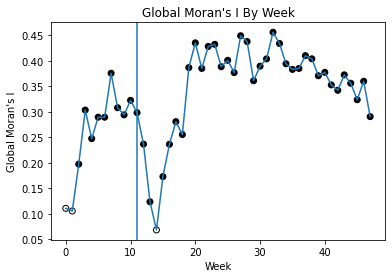

In [11]:
# formatting for plotting and coloring 
x_val = []
y_val = []
face_color = []

# changes face color depending on significance 
for i in range(len(moranlist)):
    x_val.append(i)
    y_val.append(moranlist[i][0])
    if moranlist[i][1]>=.05:
        face_color.append('white')
    else:
        face_color.append('black')

#  plotting
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val,c=face_color, edgecolors = 'black')
plt.title('Global Moran\'s I By Week')
plt.xlabel('Week')
plt.ylabel('Global Moran\'s I')
plt.axvline(11)
plt.show()

/Users/dylanfu/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/splot/_viz_esda_mpl.py:792: UserWarning: To change the color use cmap with a colormap of 5,
 color defines the LISA category
  warnings.warn('To change the color use cmap with a colormap of 5,\n' +
/Users/dylanfu/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/splot/_viz_esda_mpl.py:792: UserWarning: To change the color use cmap with a colormap of 5,
 color defines the LISA category
  warnings.warn('To change the color use cmap with a colormap of 5,\n' +
/Users/dylanfu/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/splot/_viz_esda_mpl.py:792: UserWarning: To change the color use cmap with a colormap of 5,
 color defines the LISA category
  warnings.warn('To change the color use cmap with a colormap of 5,\n' +


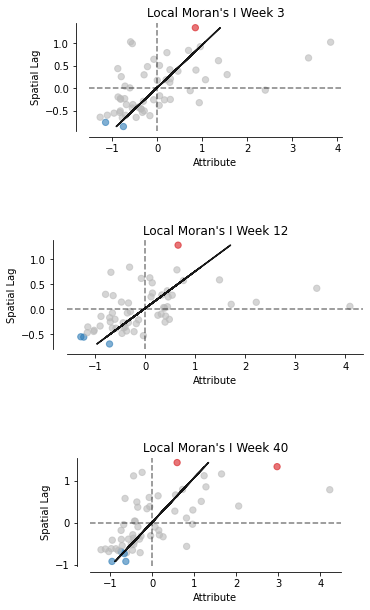

In [75]:
from splot.esda import plot_local_autocorrelation
import esda as esda
import matplotlib
colorspread = matplotlib.colors.ListedColormap(['#bababa', '#d7191c', '#abd9e9',
                                     '#bababa','#2c7bb6'])
# making the plot w/ 3 sublots of week3,week12,and week40
w = Queen.from_dataframe(weeklydata[0])
# singling out the weekly data
y_wk3 = weeklydata[3]['weighted_avg'].to_numpy()
y_wk12 = weeklydata[12]['weighted_avg']
y_wk40 = weeklydata[40]['weighted_avg']
#calculating Local Moran's I 
moran_loc3 = Moran_Local(y_wk3,w)
moran_loc12 = Moran_Local(y_wk12,w)
moran_loc40 = Moran_Local(y_wk40,w)
# plotting
fig, axs = plt.subplots(3,1, figsize = (10,10), subplot_kw = {'aspect':'equal'})
moran_scatterplot(moran_loc3, p= .01, ax = axs[0],scatter_kwds=dict(cmap = colorspread))
axs[0].set_title('Local Moran\'s I Week 3')
moran_scatterplot(moran_loc12, p= .01, ax =axs[1],scatter_kwds=dict(cmap = colorspread))
axs[1].set_title('Local Moran\'s I Week 12')
moran_scatterplot(moran_loc40, p= .01, ax =axs[2],scatter_kwds=dict(cmap = colorspread))
axs[2].set_title('Local Moran\'s I Week 40')
plt.subplots_adjust(hspace = 1)
plt.show()

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Moran Scatterplot (0.28)'}, xlabel='Attribute', ylabel='Spatial Lag'>)

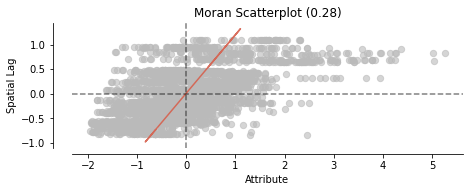

In [28]:
#scatterplot of the entire dataset
# the horizontal lines might be because the geospatial data is repeated, resulting in similar spatial lag values.
w = Queen.from_dataframe(geo_newdf)
y = geo_newdf['weighted_avg']
moran = Moran(y,w)
moran_scatterplot(moran)



(<Figure size 648x648 with 1 Axes>, <AxesSubplot:>)

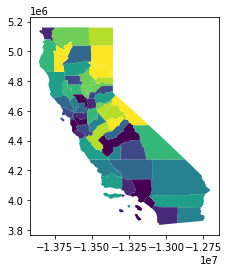

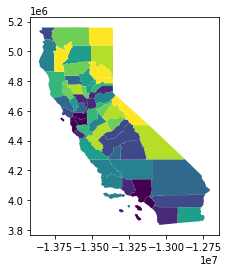

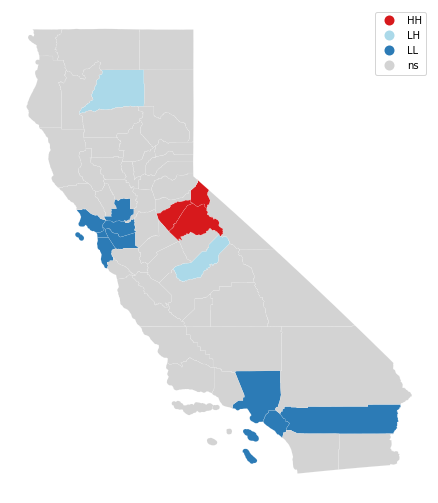

In [85]:
wk3_gdf = gpd.GeoDataFrame(weeklydata[3])
wk3_gdf.plot(column = 'weighted_avg',scheme = 'Quantiles',k= 10)
wk11_gdf = gpd.GeoDataFrame(weeklydata[11])
wk11_gdf.plot(column = 'weighted_avg',scheme = 'Quantiles',k= 10)



(<Figure size 648x648 with 1 Axes>, <AxesSubplot:>)

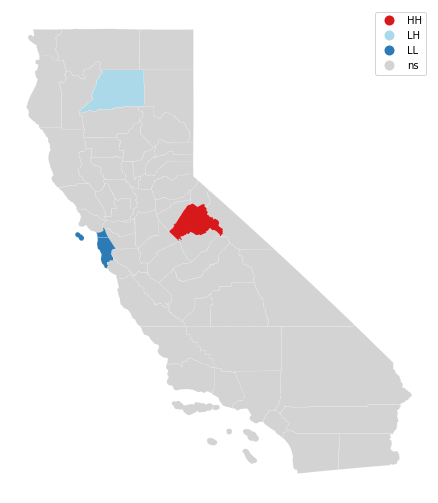

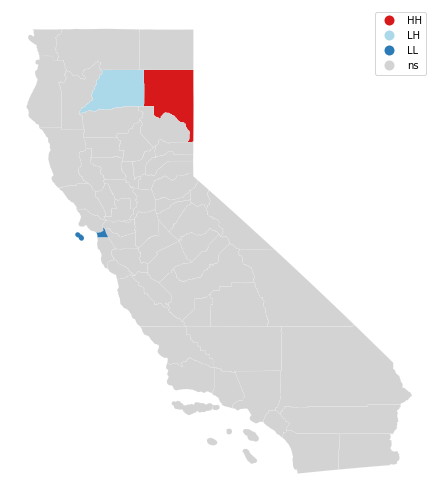

In [90]:
from splot.esda import lisa_cluster
lisa_cluster(moran_loc3, weeklydata[3], p=0.01, figsize = (9,9))
moran_loc11 = Moran_Local(weeklydata[11]['weighted_avg'],w)
lisa_cluster(moran_loc11,weeklydata[11],p=0.01,figsize = (9,9))
